In [1]:
import numpy as np
import torch
import os
import pickle
import matplotlib.pyplot as plt
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (20, 20)
# plt.rcParams['image.interpolation'] = 'bilinear'

from argparse import ArgumentParser

from torch.optim import SGD, Adam
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Normalize
from torchvision.transforms import ToTensor, ToPILImage
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import lr_scheduler
from networks.SegNet_standard import SegNet
from networks.UNet_standard import UNet

import collections
import numbers
import random
import math
from PIL import Image, ImageOps, ImageEnhance
# import logging
import time
import tool
# import bcolz

In [2]:
torch.__version__

'0.4.0'

In [2]:
CROSS_VALIDATION_FOLD = 0 # 0-4
SEED = CROSS_VALIDATION_FOLD * 100
NUM_CHANNELS = 3
NUM_CLASSES = 2 

In [3]:
def log(message):
    print(message)

In [4]:
# log('='*50 + 'start run' + '='*50)

## dataset

In [5]:
# NUM_CHANNELS = 3
# NUM_CLASSES = 2 # car is 1, background is 0

# color_transform = Colorize(n=NUM_CLASSES)
# image_transform = ToPILImage()

In [6]:
class Crop(object):
    def __init__(self, crop_size=512):
        self.crop_size = crop_size

    def __call__(self, img_and_label):
        img, label = img_and_label
        w, h = img.size
                
        img = img.crop((200, 200, 200+self.crop_size, 200+self.crop_size))
        label = label.crop((200, 200, 200+self.crop_size, 200+self.crop_size))
        
        return img, label

class Crop_different_size_for_image_and_label(object):
    def __init__(self, image_size=572, label_size=388):
        self.image_size = image_size
        self.label_size = label_size
        self.bound = (self.image_size - self.label_size) // 2

    def __call__(self, img_and_label):
        img, label = img_and_label
        w, h = img.size
        
        xcenter = 1000
        ycenter = 600
        
        img = img.crop((xcenter - self.image_size // 2, ycenter - self.image_size // 2, xcenter + self.image_size // 2, ycenter + self.image_size // 2))
        label = label.crop((xcenter - self.label_size // 2, ycenter - self.label_size // 2, xcenter + self.label_size // 2, ycenter + self.label_size // 2))
        
        return img, label

In [7]:
# random_rotate = tool.Random_Rotate_Crop(maxAngle = 10)
# crop = tool.Random_Rotate_Crop(maxAngle = 0)
crop_512 = Crop(crop_size = 512)
crop_572 = Crop_different_size_for_image_and_label()
# random_color = tool.RandomColor()
to_tensor_label = tool.ToTensor_Label()
normalize = tool.ImageNormalize([.485, .456, .406], [.229, .224, .225])
train_transforms = tool.Compose([crop_512, to_tensor_label, normalize])
train_transforms_572 = tool.Compose([crop_572, to_tensor_label, normalize])
# val_transforms = tool.Compose([crop_512, to_tensor_label, normalize])

In [8]:
image_path = '../data/images_flip/train/'
mask_path = '../data/images_flip/train_masks/'

In [9]:
with open('../data/train_shuffle_names.pk', 'rb') as f:
    filenames = pickle.load(f)

In [10]:
fold_num = len(filenames) // 5
folds = []
for i in range(5):
    if i == 4:
        folds.append(filenames[i * fold_num :])
    else:
        folds.append(filenames[i * fold_num : (i + 1) * fold_num])

train_filenames = []
for i in range(5):
    if i == CROSS_VALIDATION_FOLD:
        val_filenames = folds[i]
    else:
        train_filenames += folds[i]

In [11]:
train_filenames = train_filenames[2:3]
# val_filenames = val_filenames[:1]

In [12]:
train_set = tool.Car_dataset(image_path, mask_path, train_filenames, train_transforms_572) 
# val_set = tool.Car_dataset(image_path, mask_path, val_filenames, val_transforms) # for validation set

In [13]:
train_loader = DataLoader(train_set, num_workers=4, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_set, num_workers=4, batch_size=1) # for validation set

## dataset examples

In [14]:
train_loader.batch_size

4

In [15]:
inp, tar = train_loader.__iter__().next()

In [16]:
i = 0
inp = Variable(inp)
tar = Variable(tar)
# tar[:, 0]
t = tar[i].cpu().data.numpy()
inpu = inp[i].cpu().data.numpy()

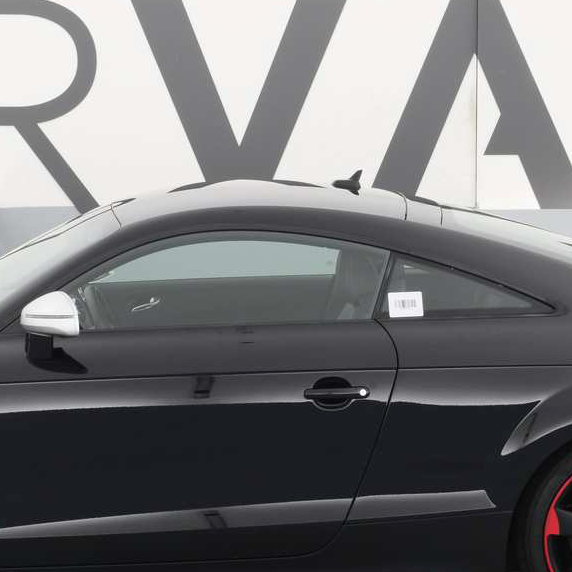

In [17]:
img_tensor = inp[i]
for ten, m, s in zip(img_tensor, [.229, .224, .225], [.485, .456, .406]):
    ten.mul_(m).add_(s)
ToPILImage()(img_tensor)

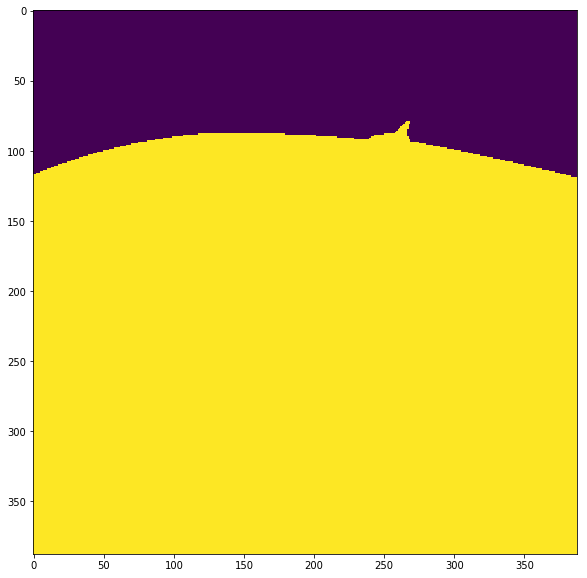

In [18]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(t[0])

## model

In [19]:
torch.cuda.manual_seed_all(SEED)

In [20]:
# model = SegNet(input_nbr=NUM_CHANNELS, label_nbr=NUM_CLASSES, pretrained=False)
model = UNet(in_channels=NUM_CHANNELS, n_classes=NUM_CLASSES)
model = model.cuda()
# load the weights for the trained model
# model.load_state_dict(torch.load('models/SegNet_5-512-0.00561.pth'))

## train define

In [21]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss2d, self).__init__()
        self.loss = nn.NLLLoss(weight, size_average)

    def forward(self, outputs, targets):
        return self.loss(F.log_softmax(outputs, dim=1), targets)

In [22]:
def train(epoch, steps_plot=0):
    model.train()

    weight = torch.ones(NUM_CLASSES)
#     weight[1] = 5 # weight of wall is 5

    criterion = CrossEntropyLoss2d(weight.cuda()) # loss function

    epoch_loss = []
    step_loss = []

    for step, (images, labels) in enumerate(train_loader):
        
        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        optimizer.zero_grad()
        loss = criterion(outputs, targets[:, 0])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        step_loss.append(loss.item())
        
        if step % 10 == 0:
            average_step_loss = sum(step_loss) / len(step_loss)
            message = 'Epoch[{}]({}/{}): \tloss: {:.4}'.format(epoch, step, len(train_loader), average_step_loss)
            log(message)
            step_loss = []
    average = sum(epoch_loss) / len(epoch_loss)
    message = 'Train: Epoch[{}] \taverage loss: {:.4}'.format(epoch, average)
    log(message)

In [23]:
def test(steps_plot = 0):
    model.eval()

    weight = torch.ones(NUM_CLASSES)
#     weight[1] = 5 # weight of wall is 5

    criterion = CrossEntropyLoss2d(weight.cuda())

#     for epoch in range(start_epoch, end_epochs+1):
    total_loss = []

    for step, (images, labels) in enumerate(val_loader):

        images = images.cuda()
        labels = labels.cuda()

        inputs = Variable(images)
        targets = Variable(labels)
        outputs = model(inputs)

        loss = criterion(outputs, targets[:, 0])

        total_loss.append(loss.item())

    average = sum(total_loss) / len(total_loss)
    message = 'Validation: \taverage loss: {:.4}'.format(average)
    log(message)
    return average

## train


In [24]:
optimizer = Adam(model.parameters(), lr = 1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.5)
val_losses = []
start_time = time.time()
epoch_num = 250
for epoch in range(epoch_num):
    scheduler.step()
    message = 'learning rate: ' + str(scheduler.get_lr()[0])
    log(message)
    train(epoch)
    log('-'*100)
    
#     if epoch == 0:
#         t1 = time.time()
#         message = 'one epoch time: ' + str(t1 - start_time) + 's'
#         log(message)
#         log('-'*100)
        
#     val_loss = test()
#     log('-'*100)
    
#     val_losses.append(val_loss)
#     if val_loss == min(val_losses) and epoch >= 100:
#         save_file_name = save_weights_path+model_name+'-fold'+str(CROSS_VALIDATION_FOLD)+'-%.5f' % val_loss+'.pth'
#         torch.save(model.state_dict(), save_file_name)
    
# end_time = time.time()
# total_time = end_time - start_time
# average_time = total_time / epoch_num
# message = 'total_time: ' + str(total_time) + 's' + '\t\taverage_time: ' + str(average_time) + 's'
# log(message)

learning rate: 0.001
Epoch[0](0/1): 	loss: 0.6629
Train: Epoch[0] 	average loss: 0.6629
----------------------------------------------------------------------------------------------------
learning rate: 0.001
Epoch[1](0/1): 	loss: 0.482
Train: Epoch[1] 	average loss: 0.482
----------------------------------------------------------------------------------------------------
learning rate: 0.001
Epoch[2](0/1): 	loss: 0.3931
Train: Epoch[2] 	average loss: 0.3931
----------------------------------------------------------------------------------------------------
learning rate: 0.001
Epoch[3](0/1): 	loss: 0.3167
Train: Epoch[3] 	average loss: 0.3167
----------------------------------------------------------------------------------------------------
learning rate: 0.001
Epoch[4](0/1): 	loss: 0.3276
Train: Epoch[4] 	average loss: 0.3276
----------------------------------------------------------------------------------------------------
learning rate: 0.001
Epoch[5](0/1): 	loss: 0.2477
Train: 

Process Process-157:
Process Process-159:
Process Process-158:
Process Process-160:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yini/.virtualenv/my_python3_env/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r

KeyboardInterrupt: 